In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

import random
import scipy.stats as stats
from scipy.stats import shapiro

#теоретические источники:
#https://habr.com/ru/companies/X5Tech/articles/740476/
#https://medium.com/@ahmadnuraziz3/applying-delta-method-for-a-b-tests-analysis-8b1d13411c22
#https://arxiv.org/pdf/2305.16459

In [2]:
serps=pd.read_csv('serps.csv')
vacs=pd.read_csv('vacs_metrics.csv')

In [3]:
serps.sample(10)

,request_id,vacancy_id_conv,city,applicant
229399,16872013147376859f95b7ea00fabf86,12071,Moscow,227785
1447882,1687168659060b65d5b7ecc35ae6a711,10255,Kazan,613340
838149,168720049695480077c5a6df12c55fa2,19171,SPb,996945
2120433,1687173591238a1e175c3c9b8d53b1c7,35860,Penza,476183
658333,1687190963541ff1b4980bf140987f67,5812,Moscow,27856
1938924,1687207852821d6f2f6536b9851e6391,21915,Penza,263048
292325,1687172460309a4f77d515b079681408,29046,Moscow,185263
1435560,16871670153632a71b5e41d60bb52c74,23428,Kazan,198211
1149446,1687147493433767f4bc03f2bea336a6,2452,SPb,334752
610485,1687203898904009c3fa7451163e051e,45330,Moscow,874233


In [4]:
vacs.sample(10)

,vacancy_id_conv,metric_full,emplpyer_id
30942,31969,5.828096,2720
19972,20550,5.115647,7743
7561,7765,4.064488,6227
53128,55425,3.705271,7719
34786,35993,3.802756,4724
47809,49663,1.024158,557
53247,55552,4.768821,2339
26160,26997,4.587193,2234
45110,46807,3.516500,1831
15474,15933,5.759100,3607


In [5]:
requests=pd.merge(serps, vacs, how='left', on='vacancy_id_conv')
requests.head(10)
#если говорить о стратификации внутри групп разбиения, то это в данном случае можно сделать только по городу
#проверим на зависимость

,request_id,vacancy_id_conv,city,applicant,metric_full,emplpyer_id
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076,3.869807,4815
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859,5.460877,377
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212,3.836248,1063
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643,4.380258,1894
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260,4.741439,4902
5,168719525526659303f2dee867dc6eda,37191,Moscow,689062,4.520380,5979
6,16872048958284676d7c2dbea61956b4,52237,Moscow,535810,4.292863,1188
7,1687159712663644f4563768f4243501,14034,Moscow,121345,5.953492,6470
8,1687159712663644f4563768f4243501,10508,Moscow,442921,3.401498,8413
9,1687159712663644f4563768f4243501,17078,Moscow,193699,4.394812,1029


In [6]:
requests.groupby('vacancy_id_conv')['city'].nunique().sort_values(ascending=False).head(1)
#максимальное количество городов, в которые выкладывались вакансии, больше 1
#не можем делать стратификацию по городам, данные зависимы:

vacancy_id_conv
1    5
Name: city, dtype: int64

In [7]:
requests.dtypes #проверим типы данных

request_id          object
vacancy_id_conv      int64
city                object
applicant            int64
metric_full        float64
emplpyer_id          int64
dtype: object

In [8]:
#переведем id различных элементов в объекты
requests['vacancy_id_conv']=requests['vacancy_id_conv'].astype('object')
requests['applicant']=requests['applicant'].astype('object')
requests.rename(columns={'emplpyer_id':'employer_id'}, inplace=True)
requests['employer_id']=requests['employer_id'].astype('object')

requests.dtypes

request_id          object
vacancy_id_conv     object
city                object
applicant           object
metric_full        float64
employer_id         object
dtype: object

In [9]:
#отдельно считаем количество вакансий по запросам с рассчитанной оценкой менее и не менее трех:
requests_more3=requests[requests.metric_full>=3]
requests_less3=requests[requests.metric_full<3]

count_more3=requests_more3.groupby('request_id')['metric_full'].agg('count')
count_less3=requests_less3.groupby('request_id')['metric_full'].agg('count')
count_metrics=pd.merge(pd.DataFrame(count_more3), pd.DataFrame(count_less3), on='request_id', how='outer')
count_metrics.head(10)

,metric_full_x,metric_full_y
request_id,,
168712248514145b9ed63fc4cf33782b,1.0,NaN
16871227284706532ec66d65d92499af,1.0,NaN
168712277018061aa71a818aa9c6846f,1.0,NaN
168712288675437aaa010736bb21b50a,1.0,NaN
168712291429376e84ab68e563b66db8,1.0,NaN
1687122938586338c896153071eb880b,1.0,NaN
1687123124675bf4f1bcb1ca1241370c,1.0,NaN
168712321499717c7a9771e6a4cda870,1.0,NaN
1687123243565b4530c2d993fac758c2,5.0,NaN


In [10]:
count_metrics.rename(columns={'metric_full_x':'more3_count', 'metric_full_y':'less3_count'}, inplace=True)
count_metrics.head(10)

,more3_count,less3_count
request_id,,
168712248514145b9ed63fc4cf33782b,1.0,NaN
16871227284706532ec66d65d92499af,1.0,NaN
168712277018061aa71a818aa9c6846f,1.0,NaN
168712288675437aaa010736bb21b50a,1.0,NaN
168712291429376e84ab68e563b66db8,1.0,NaN
1687122938586338c896153071eb880b,1.0,NaN
1687123124675bf4f1bcb1ca1241370c,1.0,NaN
168712321499717c7a9771e6a4cda870,1.0,NaN
1687123243565b4530c2d993fac758c2,5.0,NaN


In [11]:
#посчитаем долю целевой метрики аб-теста для каждого запроса
count_metrics.replace(np.nan, 0, inplace=True)
count_metrics['share_less3']=count_metrics['less3_count']/(count_metrics['less3_count']+count_metrics['more3_count']) 
count_metrics.sort_values(by='less3_count', ascending=False)

,more3_count,less3_count,share_less3
request_id,,,
1687172902251a1750dec6b693a56090,9.0,41.0,0.820000
1687193616013f9aa0cf018b0fd4c384,27.0,14.0,0.341463
1687196555314a7f83d0d6ffdec9736b,27.0,14.0,0.341463
16871837329262cc94cc9cd77c84d8c7,24.0,14.0,0.368421
1687166901816f2aaabe1062af4dc8cb,24.0,14.0,0.368421
...,...,...,...
168717148143969ba80528cb230e43d1,2.0,0.0,0.000000
1687171481441639e8d2ffca5f9b4b31,3.0,0.0,0.000000
16871714815250b74aac575e872a30f7,1.0,0.0,0.000000


In [12]:
#также добавим столбец с общим количеством вакансий в запросе,
#поскольку при одинаковой доле вакансий с оценкой менее 3 их общее количество может быть различным 

count_metrics['count']=count_metrics['more3_count']+count_metrics['less3_count']
count_metrics.head(10)

,more3_count,less3_count,share_less3,count
request_id,,,,
168712248514145b9ed63fc4cf33782b,1.0,0.0,0.0,1.0
16871227284706532ec66d65d92499af,1.0,0.0,0.0,1.0
168712277018061aa71a818aa9c6846f,1.0,0.0,0.0,1.0
168712288675437aaa010736bb21b50a,1.0,0.0,0.0,1.0
168712291429376e84ab68e563b66db8,1.0,0.0,0.0,1.0
1687122938586338c896153071eb880b,1.0,0.0,0.0,1.0
1687123124675bf4f1bcb1ca1241370c,1.0,0.0,0.0,1.0
168712321499717c7a9771e6a4cda870,1.0,0.0,0.0,1.0
1687123243565b4530c2d993fac758c2,5.0,0.0,0.0,5.0


In [13]:
#хотим воспользоваться дельта-методом в сочетании с t-критерием Стьюдента

#надо проверить нормальность распределения средних выборочных данных по случайным величинам, отношение которых мы рассматриваем
#доля X/Y в нашем случае состоит из X (количество вакансий в запросах с оценкой меньше 3) и Y (количество всех вакансий в запросах)

#построим распределение из 1000 средних x по сгенерированным выборкам: 

chosen_mean_y=[]
for i in range(1000):
    new_sample=random.sample(list(count_metrics['count']), 10000)
    new_mean=np.mean(new_sample)
    chosen_mean_y.append(new_mean)

ShapiroResult(statistic=0.9985055327415466, pvalue=0.5582453608512878)

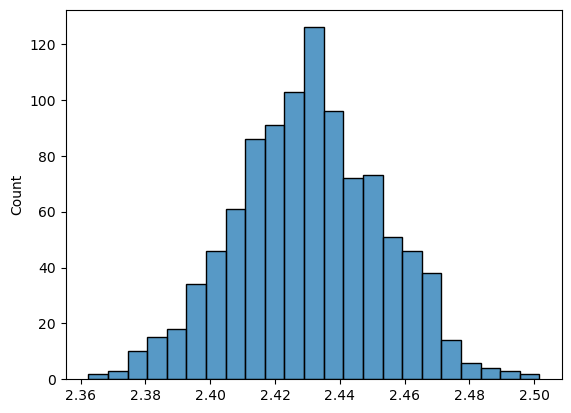

In [14]:
sns.histplot(chosen_mean_y)
#количество сгенерированных средних меньше 5000, поэтому можем использовать тест Шапиро-Уилка
shapiro(chosen_mean_y)
#p-value больше уровня значимости 0.05, поэтому мы не отклоняем гипотезу о нормальности распределения среднего количества вакансий в запросе

ShapiroResult(statistic=0.9975728392601013, pvalue=0.14584165811538696)

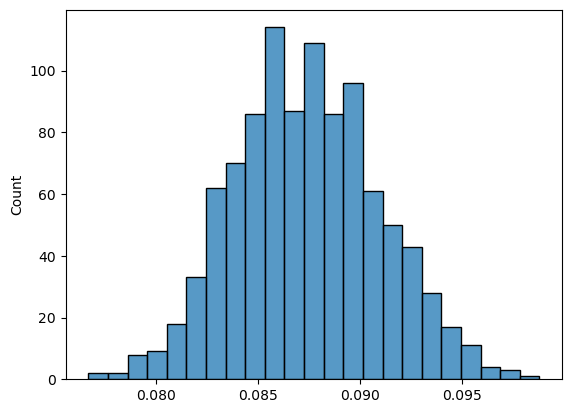

In [15]:
#проведем аналогичные действия со случайной величиной Х: 

chosen_mean_x=[]
for i in range(1000): 
    new_sample=random.sample(list(count_metrics['less3_count']), 10000)
    new_mean=np.mean(new_sample)
    chosen_mean_x.append(new_mean)
sns.histplot(chosen_mean_x)
shapiro(chosen_mean_x) 
#аналогично не отклоняем гипотезу о нормальности случайной величины - количества вакансий в запросе с низкими скорами (ниже 3)
#следовательно, можем использовать дельта-метод в сочетании с t-тестом 

In [16]:
requests.request_id.nunique()

1000000

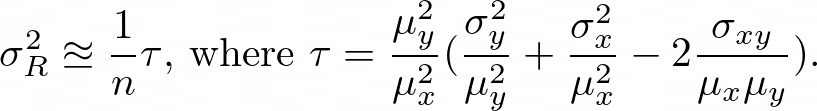 

In [17]:
#очевидно, количество запросов для разбиения их всех 50/50 на контрольную и тестовую группы крайне велико

#дельта-метод подразумевает расчет отдельной оценки дисперсии отношения этих двух случайных величин, то есть метрики-отношения
#рассчитаем аппроксимированную дисперсию для метрик-отношения по формуле выше

less3_count=count_metrics['less3_count']
overall_count=count_metrics['count']

def tau_delta_method(chosen_mean_x, chosen_mean_y):
    mu_x, mu_y=np.mean(chosen_mean_x), np.mean(chosen_mean_y)
    mu_x2, mu_y2=mu_x**2, mu_y**2
    
    var_x, var_y=np.array(chosen_mean_x).var(), np.array(chosen_mean_y).var()
    
    sigma_xy=np.cov(chosen_mean_x, chosen_mean_y)[0][1]
    
    tau=(var_x/mu_y2+mu_x2*var_y/(mu_y**4)-2*(sigma_xy)*(mu_x)/(mu_y**3))
    
    var_ratio=tau/len(chosen_mean_x)
    return var_ratio, tau

var_ratio, tau=tau_delta_method(less3_count, overall_count)

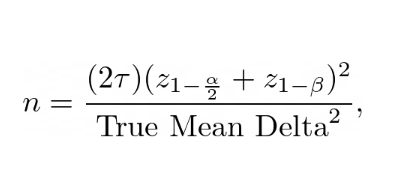

In [18]:
#def size_of_ab_samples(tau, mu_x, mu_y, mde_rel, alpha, beta):
#    za=stats.norm.ppf(1-alpha/2)
#    zb=stats.norm.ppf(1-beta)
    
#   n=(2*tau*((za+zb)**2))/(((mu_x/mu_y)*mde_rel)**2)
    
#   return n 

In [19]:
#данные расчеты из-за того, что мы рассматриваем абсолютный прирост (константу), а не относительный (случайную величину), будет в случае с метрикой-отношения давать не совсем корректные результаты по размеру выборки
#абсолютный прирост будет давать в данном случае знаменатель, приблизительно равный нулю, если мы берем % относительного прироста небольшим
#поэтому предпочтительнее возпользоваться модифицированной формулой с использованием относительного прироста (h в данном случае=tau, k=n)
#в данной формуле mu_x - это среднее значение метрики-отношения  в контрольной группе
#mu_y тогда среднее значение в тестовой группе (=mu_x*(1+i), i - доля относительного ожидаемого прироста)

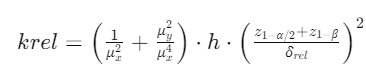

In [20]:
#нет данных о динамике дисперсии/указании временного промежутка, чтобы рассчитать дисперсию за период
#также в связи с этим мы не можем оценить длительность тестирования, поэтому придется пренебречь потенциальной цикличностью в сфере поиска работы
#берем общую дисперсию по всем данным из предположения, что она стабильна

def size_of_ab_samples(less3_count, overall_count, tau, alpha, beta, mde_rel):
    za=stats.norm.ppf(1-alpha/2)
    zb=stats.norm.ppf(1-beta)
    control_ratio=less3_count.sum()/overall_count.sum()
    test_ratio=control_ratio*(1+mde_rel)
    
    n=tau*((za+zb)/mde_rel)**2*(1/(control_ratio**2)+(test_ratio**2)/(control_ratio**4))
    return n

In [21]:
#предположим, что относительный mde, который покроет расходы на внедрение и тестирование, равен 5%
#уровень ошибок первого и второго рода также возьмем стандартные - 0.05 и 0.2
size_5=round(size_of_ab_samples(less3_count, overall_count, tau, 0.05, 0.2, 0.05)) 
print(size_5)

#тогда размер каждой из выборок (контрольной и тестовой) должен оказаться приблизительно на этом уровне
#данных о времени или цикличности просмотров нет 
#рассчитываем время проведения тестов исходя из того, что за период на hh соберется необходимое и достаточное число  наблюдений

94553


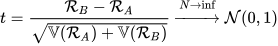

In [22]:
#Поскольку решили использовать дельта-метод в сочетании с t-статистикой,
#после теста необходимо будет воспользоваться данной формулой, создадим функцию

def t_test_delta(control_group_less3, test_group_less3, control_group_overall, test_group_overall):
    mean_control=control_group_less3.sum()/control_group_overall.sum()
    mean_test=test_group_less3.sum()/test_group_overall.sum()
    var_control, tau_control=tau_delta_method(control_group_less3, control_group_overall)
    var_test, tau_test=tau_delta_method(test_group_less3, test_group_overall)
    
    t=(mean_test-mean_control)/np.sqrt(var_control+var_test)
    pvalue=stats.t.sf(abs(t), dx=len(control_group_overall)-1)*2
    return pvalue


In [23]:
#Проведем синтетические aa-тесты, чтобы проверить уровень ошибки первого рода: 

pv_first=[]

for i in range(1000):
    test_indx=np.random.choice(count_metrics.index, size=size_5, replace=True)
    control_indx=np.random.choice(count_metrics.index, size=size_5, replace=True)

    control_values=count_metrics.loc[control_indx][['less3_count', 'count']]
    test_values=count_metrics.loc[test_indx][['less3_count', 'count']]
    
    control_mean=control_values['less3_count'].sum()/control_values['count'].sum()
    test_mean=test_values['less3_count'].sum()/test_values['count'].sum()
    
    control_var, tau_control=tau_delta_method(control_values['less3_count'], control_values['count'])
    test_var, tau_test=tau_delta_method(test_values['less3_count'], test_values['count'])
    
    t_sample=(test_mean-control_mean)/np.sqrt(control_var+test_var)
    pvalue_on_sample=stats.t.sf(abs(t_sample), df=size_5-1) * 2
    
    if pvalue_on_sample<0.05:
        pv_first.append(pvalue_on_sample)
share_first=len(pv_first)/1000
print(share_first)    

0.049


In [24]:
pv_second=[]

for i in range(1000):
    test_indx=np.random.choice(count_metrics.index, size=size_5, replace=True)
    control_indx=np.random.choice(count_metrics.index, size=size_5, replace=True)

    control_values=count_metrics.loc[control_indx][['less3_count', 'count']]
    test_values=count_metrics.loc[test_indx][['less3_count', 'count']]
    
    control_mean=control_values['less3_count'].sum()/control_values['count'].sum()
    test_mean=test_values['less3_count'].sum()/test_values['count'].sum()*1.05
    
    control_var, tau_control=tau_delta_method(control_values['less3_count'], control_values['count'])
    test_var, tau_test=tau_delta_method(test_values['less3_count'], test_values['count'])
    
    t_sample=(test_mean-control_mean)/np.sqrt(control_var+test_var)
    pvalue_on_sample=stats.t.sf(abs(t_sample), df=size_5-1)*2 
    
    if pvalue_on_sample<0.05: 
        pv_second.append(pvalue_on_sample)
power=len(pv_second)/1000
print(power)

0.831


In [25]:
#Синтетические тесты показали, что уровень ошибки первого рода и ошибки второго рода находятся приблизительно на заданном уровне
#а=0.05, б=0.2
#Также вместо дельта-метода с т-тестом можно было бы использовать z-тест для пропорций или воспользоваться бутстрапом
#Н-р, рассчитать доверительные интервалы для разности отношений

#По окончании сбора необходимого количества можно использовать дополнительно критерий хи2 Пирсона для проверки пропорции групп